### Выполнил: Сахабутдинов Айдар

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
from datetime import datetime
from IPython.display import Image

%matplotlib inline

In [2]:
# Выгружаем данные

# customers — таблица с уникальными идентификаторами пользователей
customers = pd.read_csv('olist_customers_dataset.csv')

# orders — таблица заказов
orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 
                                                             'order_approved_at',
                                                             'order_delivered_carrier_date',
                                                             'order_delivered_customer_date',
                                                             'order_estimated_delivery_date'])

# items — товарные позиции, входящие в заказы
items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

### EDA

Проверим, есть ли в наших данных пропущенные значения и дубликаты.

In [3]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [4]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [5]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [6]:
print(orders.duplicated().sum())
print(customers.duplicated().sum())
print(items.duplicated().sum())

0
0
0


Дубликатов нет, однако есть пропущенные значения в столбцах "время подтверждения оплаты заказа", "время передачи заказа в логистическую службу" и "время доставки заказа" в таблице orders. Скорее всего, это связано с тем, что еще не все заказы были доставлены до пункта назначения. Так что эти данные не удаляем.

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Для начала, нам нужно определить, что мы будем считать "покупкой". Посмотрев на данные по статусам заказа, кажется логичным отбросить заказы со статусом "отменен" ("canceled") и "недоступен" ("unavailable").
В наших данных также есть заказы, которые считаются "отмененными" или "недоступными", но при этом есть факт оплаты (если смотреть на столбец "order_approved_at" в таблице orders). Однако, такие заказы могли быть оплачены и после отменены, а сам товар возвращен, как деньги и владельцу (в таблице, к сожалению, нет информации по поводу возвратов). Поэтому в данном случае будем считать, что все "отмененные" и "недоступные" заказы не являются покупкой.
Также для более удобного восприятия создадим отдельный столбец "paid", где будет указано, было ли по заказу указано время оплаты (то есть order_approved_at.notna()). Если True, значит время оплаты указано, что доказывает, что деньги были внесены. Тем самым, мы можем считать такой заказ "покупкой". Если значение в столбце False, значит время оплаты не указано, то есть оплаты не было.

In [7]:
# Создадим новую колонку

orders['paid'] = orders.order_approved_at.notna()

In [8]:
# Создадим новую таблицу только с реальными покупками

purchases = orders[(orders.order_status != 'unavailable') & 
                     (orders.order_status != 'canceled') & 
                     (orders.paid == True)]

In [9]:
purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,True
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,True
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,True
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,True
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,True


Далее соединим наш новый датафрейм purchases, в котором указаны только настоящие покупки, с таблицей customers для того, чтобы получить уникальные идентификаторы пользователей.

In [10]:
purchases_df = purchases[['order_id', 'customer_id']].merge(customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

In [11]:
purchases_df.head()

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6


In [12]:
# Проверим новую таблицу на наличие пропущенных значений

purchases_df.isna().sum()

order_id              0
customer_id           0
customer_unique_id    0
dtype: int64

Для того, чтобы найти количество пользователей, которые совершили только одну покупку, нужно таблицу purchases сгруппировать по уникальному идентификатору пользователя и посчитать количество его совершенных заказов. После отфильтровать только тех пользователей, у которых количество заказов равняется 1.

In [13]:
only_one_order = purchases_df.groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id': 'count'}) \
    .rename(columns={'customer_id': 'order_amount'}) \
    .query('order_amount == 1')

only_one_order.head()

,customer_unique_id,order_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [14]:
print('{}% всех пользователей совершили только одну покупку. Их всего — {}'.format(
    round(100 * only_one_order.shape[0] / purchases_df.customer_unique_id.nunique(), 2), only_one_order.shape[0]))

96.96% всех пользователей совершили только одну покупку. Их всего — 92087


Оказывается, большая часть наших покупателей совершили всего лишь одну покупку

##### Ответ: Количество уникальных пользователей, которые совершили покупку только один раз — 92087.

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

В данном случае нам для начала также стоит определиться с определенным понятием, а именно — какой заказ мы считаем "не дошедшим до конечной точки". Здесь, как указано в самом вопросе, может быть несколько причин. По моему мнению, наиболее оптимальным вариантом является следующее разделение заказов, не дошедших по своих покупателей:

1) Заказ отменен (т.е. "order_status == canceled"), однако при этом не было даты доставки до покупателя (то есть "order_delivered_customer_date.isna()". Это делается для того, чтобы не учитывать те заказы, которые доставились до пункта назначения (так как указана дата доставки), но были отменены, так как, по факту, у данных заказов проблем с доставкой не было, покупатель просто отменил свой заказ. Предполагается, что данный товар после был благополучно возвращен на склад. (см.пункт 2.1)

2) Заказ недоступен (т.е. "order_status == unavailable"). У нас просто недостаточно причин, чтобы засчитать данный заказ, как "ликвидный", и у нас также нет данных по их датам выгрузки со склада или датам доставки до покупателя.(см.пункт 2.2)

3) Заказ, который указан, как "доставлен", однако нет даты доставки. Скорее всего, это заказы, у которых забаговались данные при логировании.(см.пункт 2.3)

In [15]:
# Создадим новый датафрейм, у которого на месте индекса будут даты создания заказа

orders_with_timeindex = orders.set_index('order_purchase_timestamp')
orders_with_timeindex.head()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid
order_purchase_timestamp,,,,,,,,
2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,True
2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,True
2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,True
2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,True
2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,True


In [16]:
# Пункт 2.1. Посчитаем отмененные заказы

canceled_orders= orders_with_timeindex[(orders_with_timeindex.order_status == 'canceled') & 
                                       (orders_with_timeindex.order_delivered_customer_date.isna())] \
                                       .resample("M").order_id.count().reset_index() \
                                       .rename(columns={'order_id': 'canceled_order_amount'})
canceled_orders

,order_purchase_timestamp,canceled_order_amount
0,2016-09-30,2
1,2016-10-31,19
2,2016-11-30,0
3,2016-12-31,0
4,2017-01-31,3
5,2017-02-28,17
6,2017-03-31,33
7,2017-04-30,18
8,2017-05-31,29
9,2017-06-30,16


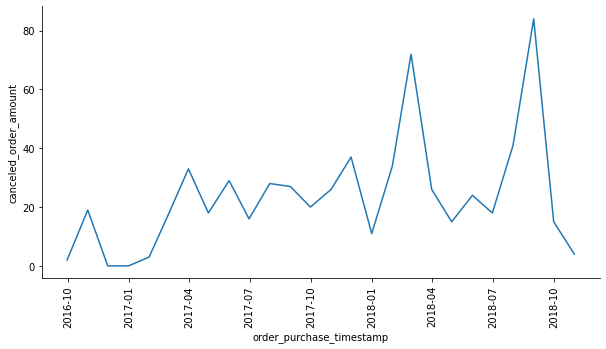

In [17]:
# Для наглядности построим график lineplot

plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.lineplot(x='order_purchase_timestamp', y='canceled_order_amount', data=canceled_orders)
sns.despine()

In [18]:
# Посчитаем среднее значение недоставленных товаров по причине отмены

print('Среднее для отмененных заказов:')
print(round(canceled_orders.canceled_order_amount.mean(), 2))

Среднее для отмененных заказов:
23.81


In [19]:
# Пункт 2.2. Посчитаем недоступные заказы

unavailable_orders = orders_with_timeindex[orders_with_timeindex.order_status == 'unavailable'] \
                            .resample("M").order_id.count().reset_index() \
                            .rename(columns={'order_id': 'unavailable_order_amount'})
unavailable_orders

,order_purchase_timestamp,unavailable_order_amount
0,2016-10-31,7
1,2016-11-30,0
2,2016-12-31,0
3,2017-01-31,10
4,2017-02-28,45
5,2017-03-31,32
6,2017-04-30,9
7,2017-05-31,31
8,2017-06-30,24
9,2017-07-31,52


Как видно из таблицы, если считать количество недоставленных товаров, которые считаются недоступными, то некоторые месяца не указываются. Поэтому в данном случае среднее значение можно посчитать 2-мя способами:

1) Взять среднее только от тех месяцев, которые указаны в таблице

2) Взять среднее, учитывая все месяцы (всего их 26 в нашей общей таблице)

In [20]:
# Посчитаем средние для недоступных заказов

print('Средние для недоступных заказов:')

# Первый способ
print('Первым способом — ', round(unavailable_orders.unavailable_order_amount.mean(), 2))

# Второй способ
print('Вторым способом — ', round(unavailable_orders.unavailable_order_amount.sum() / 26, 2))

Средние для недоступных заказов:
Первым способом —  26.48
Вторым способом —  23.42


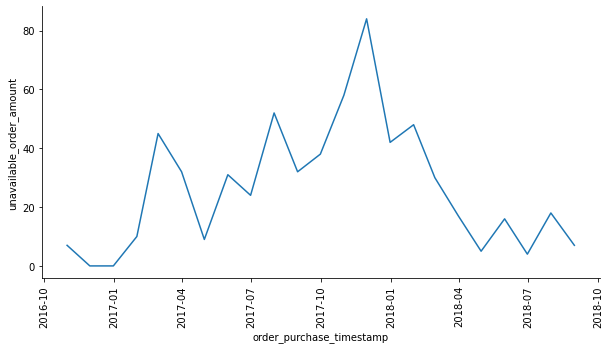

In [21]:
# Для наглядности построим график lineplot

plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
sns.lineplot(x='order_purchase_timestamp', y='unavailable_order_amount', data=unavailable_orders)
sns.despine()

In [22]:
# Пункт 2.3. Посчитаем забагованные заказы

bugged_orders = orders_with_timeindex[(orders_with_timeindex.order_status == 'delivered') & 
                      (orders_with_timeindex.order_delivered_customer_date.isna())] \
                      .resample("M").order_id.count().reset_index() \
                      .rename(columns={'order_id': 'bugged_order_amount'})
bugged_orders

,order_purchase_timestamp,bugged_order_amount
0,2017-05-31,1
1,2017-06-30,0
2,2017-07-31,0
3,2017-08-31,0
4,2017-09-30,0
5,2017-10-31,0
6,2017-11-30,1
7,2017-12-31,0
8,2018-01-31,0
9,2018-02-28,0


Здесь аналогичная ситуация с количеством месяцев

In [23]:
# Посчитаем средние для забагованных заказов

print('Средние для забагованных заказов:')

# Первый способ
print('Первым способом — ', round(bugged_orders.bugged_order_amount.mean(), 2))

# Второй способ
print('Вторым способом — ', round(bugged_orders.bugged_order_amount.sum() / 26, 2))

Средние для забагованных заказов:
Первым способом —  0.53
Вторым способом —  0.31


##### Ответ: 
Среднее количество отмененных заказов — 23.81

Среднее количество недоступных заказов:

    Первым способом (учитывая только месяцы, которые в таблице для недоступных заказов) —  26.48
    
    Вторым способом (все месяцы) —  23.42
    
Среднее количество забагованных заказов:

    Первым способом (учитывая только месяцы, которые в таблице для забагованных заказов) —  0.53
    
    Вторым способом (все месяцы) —  0.31


#### P.S. ко второму заданию

В нашем случае можно было бы разделить также другие типы недоставленных заказов, однако в данной таблице такие заказы, как будет видно дальше, не получается/нет смысла выделять. 

1) В таблице items у нас есть столбец shipping_limit_date ("максимальная дата доставки продавцом для передачи заказа партнеру по логистике"). То есть можно считать, что если продавец приносит заказанный покупателем товаром в логистическую службу позднее данной даты, то он не обслуживается, тем самым, товар не доставляется и его можно считать недоставленным. (см. пункт 2.4)

2) Можно посмотреть те товары, которые были отменены из-за того, что они были доставлены позже обещанной даты (см. пункт 2.5)

Посмотрим первый тип:

In [24]:
# Для начала таблицу items сгруппируем по order_id, и сделаем агрегацию по минимальному shipping_limit_date
# Таким образом, мы сможем узнать какой товар внутри одного заказа обладаем самой скорой датой отмены

orders_by_limit_date = items.groupby('order_id') \
     .agg({'shipping_limit_date': 'min'}) \
     .reset_index()

orders_by_limit_date.head()

,order_id,shipping_limit_date
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-19 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,2017-05-03 11:05:13
2,000229ec398224ef6ca0657da4fc703e,2018-01-18 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,2018-08-15 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-13 13:57:51


In [25]:
# Соединим таблице orders с таблицей orders_by_limit_date

orders_by_limit_date = orders.merge(orders_by_limit_date, on='order_id', how='right')

In [26]:
# Для удобства выберем только нужные столбцы

orders_by_limit_date = orders_by_limit_date[['order_id', 
                                             'order_status', 
                                             'order_delivered_carrier_date', 
                                             'shipping_limit_date']]

In [27]:
# Посмотрим сколько было заказов разных статусов, где продавец доставил товар в лог.службу позже макс.даты

(orders_by_limit_date[(orders_by_limit_date.order_delivered_carrier_date > orders_by_limit_date.shipping_limit_date)]
                     ['order_status'].value_counts())

delivered    8724
shipped       127
canceled       10
Name: order_status, dtype: int64

Как видим, большая часть товаров все равно считается доставленной и только 10 штук были отменены. Поэтому нет смысла выделять данный тип товаров в категорию "недоставленные".

Проверим второй тип товаров:

In [28]:
# Посмотрим распределение статусов у тех заказов, которые были доставлены позже обещанной даты

orders[orders.order_delivered_customer_date > orders.order_estimated_delivery_date]['order_status'].value_counts()

delivered    7826
canceled        1
Name: order_status, dtype: int64

Здесь картинка примерно та же. Всего лишь один заказ, который был отменен и у которого срок доставки был позже обещанного. Поэтому и в данном случае, на мой взгляд, нет смысла выделять данную причину в отдельную категорию.

### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [29]:
# Для удобства возьмем только нужные колонки с таблицы items

products = items[['product_id', 'order_id']]
products.head()

,product_id,order_id
0,4244733e06e7ecb4970a6e2683c13e61,00010242fe8c5a6d1ba2dd792cb16214
1,e5f2d52b802189ee658865ca93d83a8f,00018f77f2f0320c557190d7a144bdd3
2,c777355d18b72b67abbeef9df44fd0fd,000229ec398224ef6ca0657da4fc703e
3,7634da152a4610f1595efa32f14722fc,00024acbcdf0a6daa1e931b038114c75
4,ac6c3623068f30de03045865e4e10089,00042b26cf59d7ce69dfabb4e55b4fd9


In [30]:
# Соединим таблицу products с таблицей purchases для того, чтобы отобрать только реальные покупки
# Также добавим колонку с названием недели, когда была произведена покупка

items_with_dates = products.merge(purchases[['order_id', 'order_approved_at']], on='order_id')
items_with_dates['day_of_week'] = items_with_dates.order_approved_at.dt.day_name()
items_with_dates.head()

,product_id,order_id,order_approved_at,day_of_week
0,4244733e06e7ecb4970a6e2683c13e61,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 09:45:35,Wednesday
1,e5f2d52b802189ee658865ca93d83a8f,00018f77f2f0320c557190d7a144bdd3,2017-04-26 11:05:13,Wednesday
2,c777355d18b72b67abbeef9df44fd0fd,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:48:30,Sunday
3,7634da152a4610f1595efa32f14722fc,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:10:18,Wednesday
4,ac6c3623068f30de03045865e4e10089,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 14:10:13,Saturday


In [31]:
# Для того, чтобы найти в какой день недели товар чаще всего покупается, нам нужно найти день, который встречается чаще всего,
# т.е., моду данного значения

products_with_most_freq_days = items_with_dates.groupby('product_id', as_index=False) \
                                               .agg({'day_of_week': pd.Series.mode})

##### Ответ:

In [32]:
products_with_most_freq_days.head()

,product_id,day_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Friday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [33]:
# Для удобства сделаем отдельный датафрейм, который является соединением таблицы customers и purchases

users_df = customers[['customer_id', 'customer_unique_id']].merge(purchases[['customer_id', 'order_approved_at']],
                                                       on='customer_id')

# Также добавим 2 колонки: месяц покупки и количество недель в месяце

users_df['month'] = users_df.order_approved_at.dt.month_name()
users_df['weeks_in_month'] = round(users_df.order_approved_at.dt.days_in_month / 7, 2)

users_df.head()

,customer_id,customer_unique_id,order_approved_at,month,weeks_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,May,4.43
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,January,4.43
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,May,4.43
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,March,4.43
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,July,4.43


In [34]:
# Найдем количество покупок для каждого пользователя по месяцам

order_amount_by_users = users_df.groupby(['customer_unique_id', 'month'], as_index=False) \
        .agg({'customer_id': 'count'}) \
        .rename(columns={'customer_id': 'order_amount'}) \
        .sort_values('customer_unique_id')

order_amount_by_users.head()

,customer_unique_id,month,order_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,May,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,1
2,0000f46a3911fa3c0805444483337064,March,1
3,0000f6ccb0745a6a4b88665a16c9f078,October,1
4,0004aac84e0df4da2b147fca70cf8255,November,1


In [35]:
# Найдем общее количество недель в месяц для каждого пользователя по месяцам

weeks_in_month_by_users = users_df.groupby(['customer_unique_id', 'month'], as_index=False) \
                                  .agg({'weeks_in_month': 'sum'})

weeks_in_month_by_users.head()

,customer_unique_id,month,weeks_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,May,4.43
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,4.43
2,0000f46a3911fa3c0805444483337064,March,4.43
3,0000f6ccb0745a6a4b88665a16c9f078,October,4.43
4,0004aac84e0df4da2b147fca70cf8255,November,4.29


In [36]:
# Объединим две вышесозданные таблицы

weekly_purchases_in_month_by_users = order_amount_by_users.merge(weeks_in_month_by_users, on=['customer_unique_id', 'month'])
weekly_purchases_in_month_by_users.head()

,customer_unique_id,month,order_amount,weeks_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,May,1,4.43
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,1,4.43
2,0000f46a3911fa3c0805444483337064,March,1,4.43
3,0000f6ccb0745a6a4b88665a16c9f078,October,1,4.43
4,0004aac84e0df4da2b147fca70cf8255,November,1,4.29


In [37]:
# Посчитаем для каждого пользователя среднее количество покупок в неделю

weekly_purchases_in_month_by_users['avg_purchases_per_week'] = round(weekly_purchases_in_month_by_users.order_amount / weekly_purchases_in_month_by_users.weeks_in_month, 2)

##### Ответ:

In [38]:
weekly_purchases_in_month_by_users.head()

,customer_unique_id,month,order_amount,weeks_in_month,avg_purchases_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,May,1,4.43,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,May,1,4.43,0.23
2,0000f46a3911fa3c0805444483337064,March,1,4.43,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,October,1,4.43,0.23
4,0004aac84e0df4da2b147fca70cf8255,November,1,4.29,0.23


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

Возьмем датафрейм users_df с предыдущего задания и уберем лишние колонки

In [39]:
users_df_cohort = users_df[['customer_unique_id', 'customer_id', 'order_approved_at']]
users_df_cohort.head()

,customer_unique_id,customer_id,order_approved_at
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:22:12
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:58:32
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-20 16:19:10
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 17:29:19
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 10:10:09


Для того, чтобы провести когортный анализ, нужно:

1) Выявить когорту пользователей. В нашем случае мы будем делить наших пользователей по месяцу покупки.

2) Интервал времени, в течение которого считается метрика. Это будет месяц.

3) Метрика, которая считается. Мы будем считать retention, т.е. количество пользователей, которые вернулись к нашему продукту через N-ое количество дней (в нашем случае, через месяц) после первой покупки.

In [40]:
# Создадим 2 колонки: год-месяц покупки конкретного заказа и самая первая покупка для конкретного пользователя

users_df_cohort['order_month'] = users_df_cohort['order_approved_at'].dt.to_period('M')
users_df_cohort['cohort'] = users_df_cohort.groupby('customer_unique_id')['order_approved_at'] \
                                           .transform('min').dt.to_period('M')
users_df_cohort.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,customer_unique_id,customer_id,order_approved_at,order_month,cohort
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:22:12,2017-05,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,18955e83d337fd6b2def6b18a428ac77,2018-01-12 20:58:32,2018-01,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,4e7b3e00288586ebd08712fdd0374a03,2018-05-20 16:19:10,2018-05,2018-05
3,259dac757896d24d7702b9acbbff3f3c,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13 17:29:19,2018-03,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29 10:10:09,2018-07,2018-07


In [41]:
# Сгруппируем данные по когорте и год-месяцу покупки заказа и посчитаем количество уникальных пользователей

cohort = users_df_cohort.groupby(['cohort', 'order_month']) \
                        .agg({'customer_id': pd.Series.nunique}) \
                        .rename(columns={'customer_id': 'num_customers'}) \
                        .reset_index()

# Посчитаем сколько прошло месяцев между первой покупкой и датой покупки заказа
cohort['period_number'] = (cohort.order_month - cohort.cohort).apply(attrgetter('n'))
cohort.head()

,cohort,order_month,num_customers,period_number
0,2016-09,2016-09,1,0
1,2016-10,2016-10,294,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11


In [42]:
# Трансформируем нашу таблицу так, чтобы в индексах были наши когорты, в столбцах — период после первой покупки,
# в значениях — количество уникальных пользователей, пришедших на данный период после первой покупки

cohort_pivot = cohort.pivot_table(index='cohort',
                                     columns='period_number',
                                     values='num_customers')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,294.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,749.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1699.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,5.0,NaN,NaN
2017-03,2620.0,14.0,9.0,11.0,9.0,4.0,4.0,8.0,8.0,3.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2332.0,15.0,6.0,5.0,6.0,6.0,9.0,6.0,8.0,4.0,5.0,2.0,2.0,1.0,2.0,2.0,4.0,NaN,NaN,NaN
2017-05,3612.0,20.0,18.0,14.0,11.0,15.0,17.0,5.0,9.0,11.0,10.0,12.0,8.0,2.0,8.0,10.0,NaN,NaN,NaN,NaN
2017-06,3169.0,14.0,12.0,12.0,8.0,11.0,11.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN


Для того, чтобы посчитать retention, нам нужно поделить каждую ячейку на его первое значение в строке, к которой он принадлежит. Также у нас имеются значения NaN в первых трех строках и также в середине 4-ой строки. Они появились из-за того, что на этот период не было вновь вернувшихся посетителей.

In [43]:
# Возьмем в отдельную переменную первые значения строк

cohort_size = cohort_pivot.iloc[:,0]

In [44]:
# Поделим значения ячейки на соответствующие им значения и получим таблицу retention

retention_matrix = cohort_pivot.divide(cohort_size, axis = 0).mul(100).round(2)

In [45]:
# Заполним ненужные значения NaN нулем

retention_matrix.iloc[0] = retention_matrix.iloc[0].fillna(0)
retention_matrix.iloc[1] = retention_matrix.iloc[1].fillna(0)
retention_matrix.iloc[2] = retention_matrix.iloc[2].fillna(0)
retention_matrix.iloc[3, 9] = 0

In [46]:
# Укажем максимальное значение в каждом столбце

retention_matrix.style.highlight_max()

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340000,0.000000,0.000000,0.340000,0.000000,0.340000,0.000000,0.340000,0.000000,0.340000,0.000000,0.340000,0.680000,0.680000
2016-12,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01,100.000000,0.530000,0.270000,0.130000,0.400000,0.130000,0.400000,0.130000,0.130000,0.000000,0.270000,0.270000,0.670000,0.400000,0.130000,0.130000,0.270000,0.400000,0.130000,nan
2017-02,100.000000,0.240000,0.240000,0.180000,0.410000,0.120000,0.240000,0.180000,0.060000,0.180000,0.120000,0.290000,0.120000,0.180000,0.120000,0.060000,0.060000,0.290000,nan,nan
2017-03,100.000000,0.530000,0.340000,0.420000,0.340000,0.150000,0.150000,0.310000,0.310000,0.110000,0.380000,0.110000,0.230000,0.110000,0.150000,0.230000,0.080000,0.150000,nan,nan
2017-04,100.000000,0.640000,0.260000,0.210000,0.260000,0.260000,0.390000,0.260000,0.340000,0.170000,0.210000,0.090000,0.090000,0.040000,0.090000,0.090000,0.170000,nan,nan,nan
2017-05,100.000000,0.550000,0.500000,0.390000,0.300000,0.420000,0.470000,0.140000,0.250000,0.300000,0.280000,0.330000,0.220000,0.060000,0.220000,0.280000,nan,nan,nan,nan
2017-06,100.000000,0.440000,0.380000,0.380000,0.250000,0.350000,0.350000,0.220000,0.130000,0.220000,0.320000,0.350000,0.160000,0.130000,0.220000,nan,nan,nan,nan,nan


##### Ответ: по таблице видно, что в промежутке декабрь-январь когорта с наивысшим retention на 3-й месяц является "сентябрь 2017-го года" — 0,43%.

Если предположить, что мы продаем товары ежедневного потребления или, по крайней мере, не редкие товары, то такой показатель retention очень маленький даже для когорты с наивысшим показателем. Впрочем, уже на начальной стадии было видно, что у нас довольно много покупателей, которые совершили только одну покупку, поэтому мы наблюдаем такую картину.

### 6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

In [47]:
# Для начала сгруппируем данные в таблице items по каждому заказу (order_id) и посчитаем полную сумму заказа

orders_grouped_by_price = items.groupby('order_id', as_index=False) \
     .agg({'price': 'sum'})

orders_grouped_by_price.head()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [48]:
# Соединим таблицу orders_grouped_by_price с таблицей реальных покупок purchases

orders_grouped_by_price = orders_grouped_by_price.merge(purchases[['order_id', 'customer_id']],
                                                        on='order_id',
                                                        how='inner')
orders_grouped_by_price.head()

,order_id,price,customer_id
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,3ce436f183e68e07877b285a838db11a
1,00018f77f2f0320c557190d7a144bdd3,239.90,f6dd3ec061db4e3987629fe6b26e5cce
2,000229ec398224ef6ca0657da4fc703e,199.00,6489ae5e4333f3693df5ad4372dab6d3
3,00024acbcdf0a6daa1e931b038114c75,12.99,d4eb9395c8c0431ee92fce09860c5a06
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,58dbd0b2d70206bf40e62cd34e84d795


In [49]:
# Соединим таблицу orders_grouped_by_price с таблицей users_df чтобы собрать все нужные данные в одном месте

temp_rfm_df = users_df.merge(orders_grouped_by_price, 
                          on='customer_id')

# Отбросим ненужные колонки

temp_rfm_df = temp_rfm_df.drop(['month', 'weeks_in_month', 'order_id'], 
                         axis=1)
temp_rfm_df.head()

,customer_id,customer_unique_id,order_approved_at,price
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,230.00


Для того, что провести RFM-анализ, нужно определить параметры recency (R), frequency (F) и monetary (M).

В нашем случае:

1) R - время от последней покупки пользователя до текущей даты

2) F - суммарное количество покупок у пользователя за всё время 

3) M - сумма покупок за всё время

In [50]:
# Введем переменную, которая будет определять текущий день

TODAY = datetime.today()
TODAY

datetime.datetime(2022, 9, 11, 21, 11, 32, 278423)

In [51]:
# Создадим колонку, которая будет показывать количество дней, прошедших с даты заказа до текущего дня

temp_rfm_df['days_since_order'] = temp_rfm_df['order_approved_at'].apply(lambda x: (TODAY - x).days)

temp_rfm_df.head()

,customer_id,customer_unique_id,order_approved_at,price,days_since_order
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:22:12,124.99,1944
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:58:32,289.00,1703
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-20 16:19:10,139.94,1575
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 17:29:19,149.94,1643
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 10:10:09,230.00,1505


In [52]:
# Создадим новый датафрейм, где сгруппируем данные по уникальному пользователю и посчитаем:
# 1. recency - сколько прошло дней с момента последней покупки
# 2. frequency - количество покупок за весь период
# 3. monetary - общая сумма покупок за весь период

rfm_df = temp_rfm_df.groupby('customer_unique_id', as_index=False) \
                    .agg({'days_since_order': 'min',
                          'customer_id': 'count',
                          'price': 'sum'}) \
                    .rename(columns={'days_since_order': 'recency',
                                     'customer_id': 'frequency',
                                     'price': 'monetary'})
rfm_df.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,1585,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1588,1,18.90
2,0000f46a3911fa3c0805444483337064,2011,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1795,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,1762,1,180.00


Сейчас нужно решить на сколько подгрупп мы поделим каждый параметр. По моему мнению, для начала стоит взглянуть на распределение каждого из параметров, а также взглянуть на их квантили.

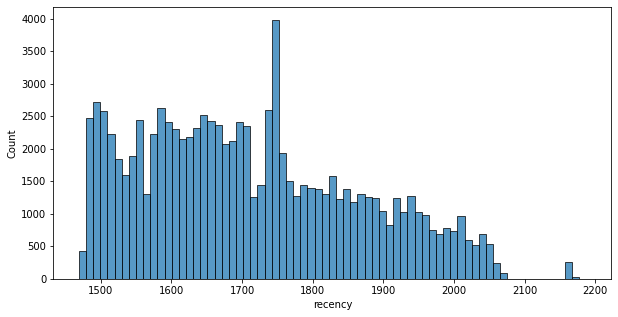

In [53]:
# Распределение параметра "recency"

plt.figure(figsize=(10,5))
sns.histplot(rfm_df.recency)

In [54]:
# 20-й, 40-й, 60-й и 80-й квантили параметра "recency"

rfm_df.recency.quantile([.2, .4, .6, .8])

0.2    1566.0
0.4    1650.0
0.6    1741.0
0.8    1857.0
Name: recency, dtype: float64

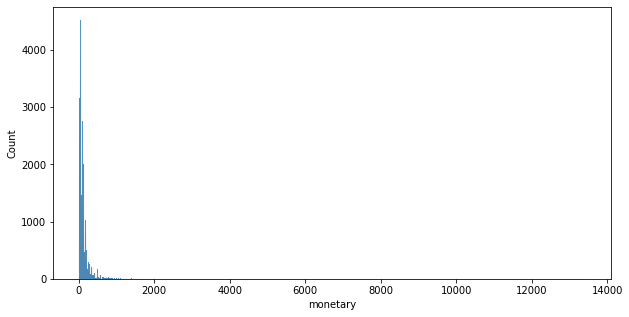

In [55]:
# Распределение параметра "monetary"

plt.figure(figsize=(10,5))
sns.histplot(rfm_df.monetary)

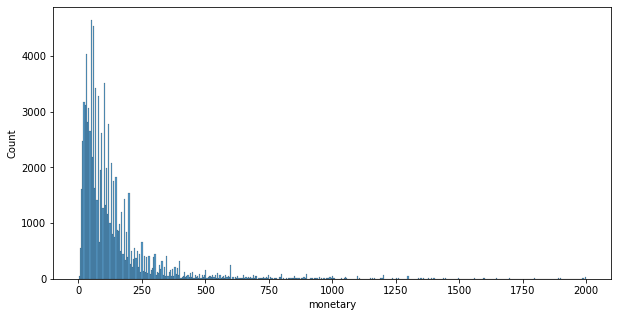

In [56]:
# Распределение параметра "monetary" для тех значений, которые ниже 2000

plt.figure(figsize=(10,5))
sns.histplot(rfm_df[rfm_df.monetary < 2000].monetary)

In [57]:
# Некоторые квантили параметра "monetary"

rfm_df.monetary.quantile([.2, .4, .6, .8, .9, .95, .99])

0.20      39.900
0.40      69.900
0.60     109.900
0.80     179.900
0.90     281.249
0.95     420.000
0.99    1004.990
Name: monetary, dtype: float64

In [58]:
# Распределение параметра "frequency"

rfm_df.frequency.value_counts()

1     92084
2      2650
3       188
4        29
5         9
6         5
7         3
16        1
9         1
Name: frequency, dtype: int64

По результатам проверки мы видим, что:

1) Распределение "recency" отличается от нормального и имеет форму чуть больше похожую на "uniform". Однако, по графику довольно ясно видно как распределен наш параметр. Как по мне, в данном случае можно взять 33-й и 66-квантили и, тем самым, разделить данный параметр на 3 категории.

2) Распределение параметра "monetary" еще более ненормальное, большая часть значений собрана слева. Также я построил доп.график, где не учитываются пользователи, которые совершили общую покупку на сумму свыше 2000. По этому графику уже видно, что большая часть покупок не превышает сумму 250. В данном случае, кажется оптимальным вариантом взять также 3 категории: пользователи до 90-го квантиля (сумма до 280) , от 90 до 99-го (сумма ~ 280-1000) и свыше 99-го квантиля (сумма свыше 1000).

3) В параметре "frequency" большая часть пользователей совершали всего лишь единственную покупку (в этом мы убедились ранее). Здесь я бы предложил разделить на следующие подгруппы: 1 - пользователи, купившие единожды; 2 - пользователи с 2-мя покупками; 3 - пользователи, совершившие 3 или 4 покупки; 4 - пользователи, которые совершили больше 5 покупок.


In [59]:
# Для этого создадим словарь с квантилями для параметров "recency" и "monetary"

quintiles = dict()
quintiles['recency'] = rfm_df['recency'].quantile([.33, .66]).to_dict()
quintiles['monetary'] = rfm_df['monetary'].quantile([.90, .99]).to_dict()
quintiles

{'recency': {0.33: 1621.0, 0.66: 1760.0},
 'monetary': {0.9: 281.24900000000287, 0.99: 1004.99}}

In [60]:
# Чем выше оценка по "recency", тем более "свежим" считается клиент, и наоборот, если значение 1, то клиент был уже давно

def r_score(x):
    if x <= quintiles['recency'][.33]:
        return 3
    elif x <= quintiles['recency'][.66]:
        return 2
    else:
        return 1

In [61]:
# Чем выше оценка по "monetary", тем большую сумму клиент потратил на заказы

def m_score(x):
    if x <= quintiles['monetary'][.9]:
        return 1
    elif x <= quintiles['monetary'][.99]:
        return 2
    else:
        return 3

In [62]:
# Чем выше оценка по "frequency", тем больше заказов сделал клиент

def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x ==3 or x == 4:
        return 3
    else:
        return 4

In [63]:
# Добавляем в нашу таблицу значения вышепосчитанных параметров

rfm_df['R'] = rfm_df['recency'].apply(lambda x: r_score(x))
rfm_df['F'] = rfm_df['frequency'].apply(lambda x: f_score(x))
rfm_df['M'] = rfm_df['monetary'].apply(lambda x: m_score(x))

rfm_df['RFM Score'] = rfm_df['R'].map(str) + rfm_df['F'].map(str) + rfm_df['M'].map(str)

rfm_df.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,1585,1,129.90,3,1,1,311
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1588,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,2011,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,1795,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,1762,1,180.00,1,1,1,111


На данном этапе наших пользователей нужно разделить на разные кластеры в зависимости от параметров "recency" и "frequency".
Как по мне, оптимальным вариантом является следующее разделение (дальше "r" - recency, "f" - frequency):

1) r = 1, f = 1 or 2 — 'highly likely lost' (покупали давно и делали всего лишь 1 или 2 заказа)

2) r = 1, f = 3 — 'at risk' (покупали 3-4 раза, но последняя активность была также давно)

3) r = 1, f = 4 — 'can't lose them' (покупали чаще всех, но очень давно)

4) r = 2 or 3, f = 1 — 'promising' (относительно недавно пришедшие пользователи, но всего лишь с одной покупкой)

5) r = 2, f = 2 — 'about to sleep' (недавние пользователи с частотой покупок ниже среднего)

6) r = 3, f = 2 — 'need attention' ("свежие пользователи" с нечастыми покупками)

7) r = 2 or 3, f = 3 — 'potential loyalists' (относительно новые клиенты, которые покупают чуть больше среднего)

8) r = 2, f = 4 — 'loyal customers' (относительно новые клиенты, покупают чаще всех)

9) r = 3, f = 4 — 'champions' (самые последние покупатели, которые покупали больше всего)

По итогу наше разбиение выглядит так (д.е. — денежные единицы):

#### Recency:
    1 — от 1760 до 2187 дней    
    2 — от 1621 до 1760 дней    
    3 — от 1469 до 1621 дней
    
#### Frequency:
    1 — 1 заказ
    2 — 2 заказа
    3 — 3 или 4 заказа
    4 — 5 и более заказов
    
#### Monetary:
    1 — от 0.85 до 281.25 д.е.
    2 — от 281.25 до 1004.99 д.е.
    3 — свыше 1004.99 д.е.

Распределение данных показателей в виде матрицы выглядит следующим образом:

In [64]:
img = 'rfm-distribution.png'
Image(url=img)

In [65]:
# Создаем словарь с такими же ключами и значениями

segt_map = {
    r'1[12]': 'highly likely lost',
    r'13': 'at risk',
    r'14': 'can\'t lose them',
    r'[23]1': 'promising',
    r'22': 'about to sleep',
    r'32': 'need attention',
    r'[23]3': 'potential loyalist',
    r'24': 'loyal customers',
    r'34': 'champions'
}

In [66]:
# Создадим отдельную колонку, используя метод "replace" и регулярные выражения
# Теперь каждый клиент зачислен в отдельный кластер в зависимости от его значений "frequency" и "recency"

rfm_df['Segment'] = rfm_df['R'].map(str) + rfm_df['F'].map(str)
rfm_df['Segment'] = rfm_df['Segment'].replace(segt_map, regex=True)
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,1585,1,129.90,3,1,1,311,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1588,1,18.90,3,1,1,311,promising
2,0000f46a3911fa3c0805444483337064,2011,1,69.00,1,1,1,111,highly likely lost
3,0000f6ccb0745a6a4b88665a16c9f078,1795,1,25.99,1,1,1,111,highly likely lost
4,0004aac84e0df4da2b147fca70cf8255,1762,1,180.00,1,1,1,111,highly likely lost


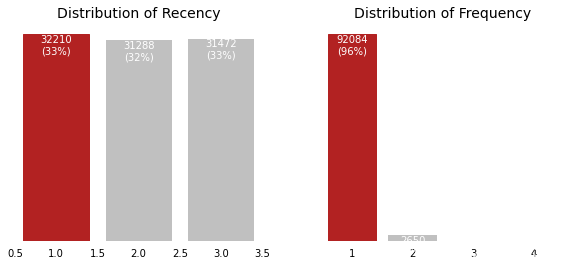

In [67]:
# Построим распределение пользователей по значенияим "recency" и "frequency"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Recency', 'F':'Frequency'}
    y = rfm_df[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

Как и видели раньше, распределение по "recency" довольно ровное, в то время как по "frequency" ясно, что больше всего клиентов, совершивших один заказ.

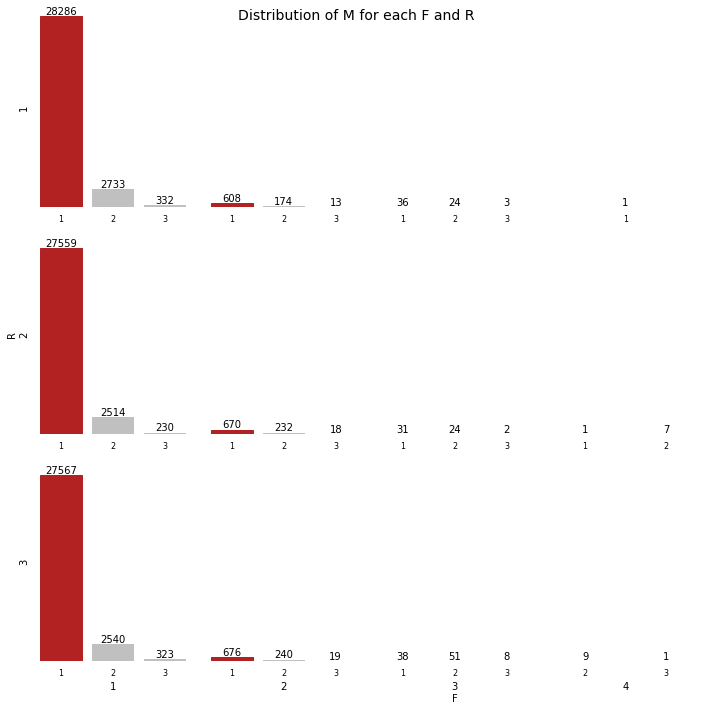

In [68]:
# Построим распределение параметра "monetary" по RF-значениям

fig, axes = plt.subplots(nrows=3, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 4)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = rfm_df[(rfm_df['R'] == r) & (rfm_df['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 3:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 2:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

Заметно, что для значений F = 3 и F = 4 пользователей очень мало (в графиках включен параметр "sharey", поэтому ось "y" для всех одна и колонок даже не видно).

Поведение остальных пользователей для F = 1 и F = 2 по разным значениям R отличается слабо: большинство клиентов покупали одну покупку (F = 1) и сумма покупки не превышала 281 д.е. (M = 1)

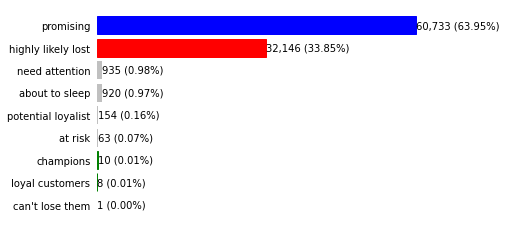

In [69]:
# Посчитаем количество пользователей для каждого кластера

segments_counts = rfm_df['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('green')
        elif segments_counts.index[i] == 'highly likely lost':
            bar.set_color('red')
        elif segments_counts.index[i] == 'promising':
            bar.set_color('blue')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:.2f}%)'.format(int(value),
                                   float(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

По барплоту мы видим, что у большая часть (~ 64%) наших пользователей находится в категории "promising" (r = 2 or 3, f = 1) и треть в категории "highly likely lost" (r = 1, f = 1 or 2), т.е. скорее всего мы их уже потеряли.

Хотелось бы узнать, какой конкретный товар мы продаем. Но можно сделать пару решений и с этими данными. Во-первых, возможно, стоит прекратить (или минимизировать) как-либо пытаться влиять на аудиторию (маркетинг и т.д.), которую мы скорее всего потеряли, так как пытаясь их задействовать, мы будем впустую тратить наши ресурсы.

Лучше стоит сконцентрироваться на более надежных пользователях. В нашем случае, это клиенты, которые попадают под категорию "promising". Напомню, это те клиенты, которые пришли относительно недавно, но сделали всего лишь одну покупку.

Пару вариантов возможных решений:

1. После того, как покупатель зарегистрировался на нашей платформе и собрал свой первый заказ, предложить ему скидку или любой другой бонус на следующую покупку.

2. Установить на платформу рекомендательную систему (предположительно, по алгоритму K-ближайших соседей), чтобы покупателю рекомендовали либо 1) такие же товары, которые он добавил к себе в заказ, либо 2) товары из той же категории, которую посетитель просматривает чаще всего. Данный способ предполагает отсутствие в компании такой ML-системы и наем доп.сотрудников по ML-Engineering, если таковых еще нет.

3. Если у пользователей, которые совершают одноразовую покупку и не появляются долгое время на платформе, есть общие черты, то возможно также с помощью машинного обучения (бинарной классификации) попробовать выявить таких клиентов и попытаться повлиять на них.